# Train

In [ ]:
import os
#MLFlow
experiment_name='conditionalDDPM'; run_name=f'speckles_flat'

#Dataset
dataset=f'speckles'; image_size=28

#Model
timesteps=1000; dim=64; n_layers=3; model_type='c'

#Hyperparameters
train_num_steps=100000; lr=0.00001; batch_size=32

os.system(f"python train.py --dataset={dataset} --experiment_name={experiment_name} --run_name={run_name} --image_size={image_size} --timesteps={timesteps} --dim={dim} --n_layers={n_layers} --model_type={model_type}  --train_num_steps={train_num_steps} --lr={lr} --batch_size={batch_size} ")  

2022/07/26 11:19:34 WARNING mlflow.tracking.context.registry: Encountered unexpected error during resolving tags: 'getpwuid(): uid not found: 1001030000'
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | GaussianDiffusion | 7.6 M 
--------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.547    Total estimated model params size (MB)
/usr/local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:112: UserWarning: The d

Epoch 86:  46%|████▌     | 12/26 [00:00<00:00, 29.04it/s, loss=0.066, v_num=c6df] 

# Test

In [15]:
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from models.DDPM import Unet, GaussianDiffusion, LitModelDDPM
# from models.DDPM_LearnSigma import Unet, GaussianDiffusion, LitModelDDPM
# from models.DDPMseq import Unet, GaussianDiffusion, LitModelDDPM
# from models.DDPMdp import Unet, GaussianDiffusion, LitModelDDPM

from utils.dataset import import_dataset

import mlflow

from mlflow.tracking.client import MlflowClient

import matplotlib.pyplot as plt

os.umask(0o002)

2

In [43]:
# MLFlow

tracking_uri='http://mlflowroute-2587054aproject.ida.dcs.gla.ac.uk/'
experiment_name='conditionalDDPM'
run_name='speckles'

# Set MLFlow
client = MlflowClient(tracking_uri)
experiment_id = client.get_experiment_by_name(experiment_name).experiment_id
runs_names = [client.get_run(run.run_id).data.params['run_name'] for run in client.list_run_infos(experiment_id)]
runs_id = [run.run_id for run in client.list_run_infos(experiment_id)]
run_id = runs_id[runs_names.index(run_name)] # Return the id corresponding to the last run with that name
run = client.get_run(run_id)

integers = ['image_size', 'dim', 'n_layers', 'save_loss_every', 'sample_every', 'timesteps', 'train_num_steps', 'batch_size']
floats = ['lr']

for param in run.data.params:
    value = run.data.params[param]
    if param in integers:
        value = int(value)
    elif param in floats:
        value = float(value)
    globals()[param] = value
    
local_path = client.download_artifacts(run_id, "model_best.pt", f'/nfs/conditionalDDPM/tmp')

# Define Dataset

train_loader, valid_loader = import_dataset(data_name = dataset, 
                                            batch_size = batch_size,
                                            image_size = image_size)

x,y = next(iter(train_loader))

if dataset.startswith('ls'):
    if dataset.endswith('full'):
        _, channels, steps, height, width = x.shape
    else:
        _, channels, height, width = x.shape
else:
    _, channels, height, width = x.shape
assert height == width, 'Image should be square'
image_size = height
condition_dim = 1 if y.ndim == 1 else channels
dim_mults = [2**i for i in range(n_layers)]

# Define Model

"""Define NN"""
model = Unet(
    dim = dim,
    dim_mults = dim_mults,
    channels = channels if model_type == 'unc' else channels+condition_dim,
    out_dim = channels, 
)

"""Define DDPM"""
diffusion = GaussianDiffusion(
                model,
                image_size = image_size,
                timesteps = timesteps,  
                loss_type = loss,  
                channels = channels,
                model_type = model_type,
                device = device
                )

"""Define Pytorch Lightning Model"""
model = LitModelDDPM( 
                diffusion_model = diffusion, 
                model_type = model_type,
                batch_size = batch_size,
                lr = lr,
                save_loss_every = save_loss_every
                )

"""Save Results at the end of the training"""
model.model.denoise_fn.load_state_dict(torch.load(f'/nfs/conditionalDDPM/tmp/model_best.pt'))

<All keys matched successfully>

In [47]:
x, y = next(iter(valid_loader))
pred = model.model.sample(y[:4].cuda(),4)

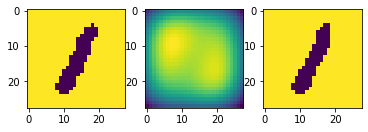

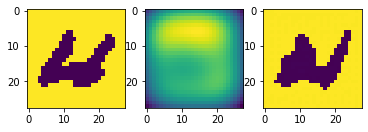

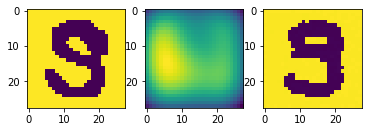

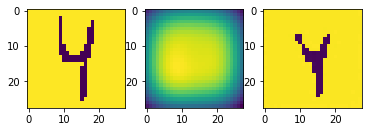

In [48]:
for N in range(4):
    fig,ax = plt.subplots(ncols=3)
    ax[0].imshow(x[N,0])
    ax[1].imshow(y[N,0])
    ax[2].imshow(pred[N,0].detach().cpu())

In [46]:
import torch.nn.functional as F

F.mse_loss(x[:4].cuda(),pred)

tensor(6.1810e-06, device='cuda:0')

# Test on Real Data

In [86]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter, median_filter

def speckles_exp(n_slabs = 1, hidden_object = 'smile', exposure=100, n_frames='10k', n_timestamp=200):
    
    bg = np.load(f'./data/speckles_exp/{n_slabs}slab_dark_exp{exposure}_{n_frames}frames.npz')['arr_0'].astype(np.int64)
    bg = bg[...,:n_timestamp]
    
    slab = np.load(f'./data/speckles_exp/{n_slabs}slab_{hidden_object}_exp{exposure}_{n_frames}frames.npz')['arr_0'].astype(np.int64)
    slab = slab[...,:n_timestamp]

#     img = np.clip(slab.sum(-1) - bg.sum(-1),0,None)
    img = np.clip(median_filter(slab.sum(-1) - bg.sum(-1), size=3),0,None)
#     img = np.clip(gaussian_filter(median_filter(slab.sum(-1) - bg.sum(-1), size=3), sigma=1),0,None)
    
    return img

x,y=[],[]
for h in ['X','L','I','G','H','T','smile']:
    
    img = torch.tensor(speckles_exp(n_slabs=1, hidden_object = h, n_frames='10k'))[None,None].float()
    img = torch.nn.functional.interpolate(img, size=(28,28),mode='bilinear')
    x.append(img)
    
    img = torch.tensor(speckles_exp(n_slabs=2,hidden_object = h, n_frames='1M'))[None,None].float()
    img = torch.nn.functional.interpolate(img, size=(28,28),mode='bilinear')
    y.append(img)
    
x = torch.cat(x,0)
x=x/x.max()
y = torch.cat(y,0)
# y=y/y.max()

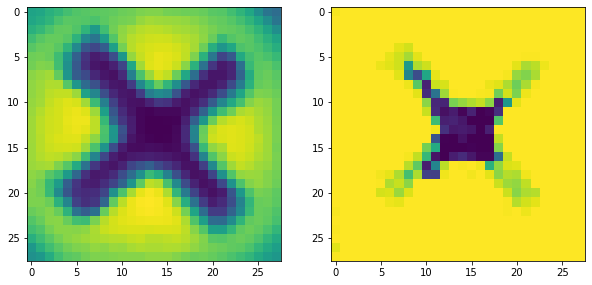

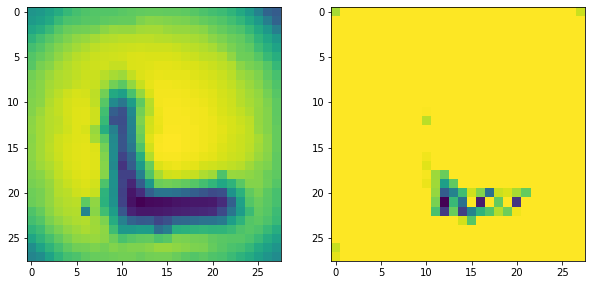

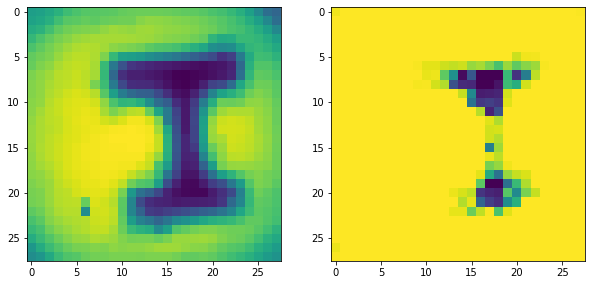

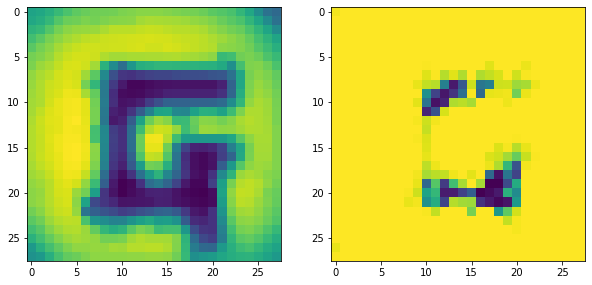

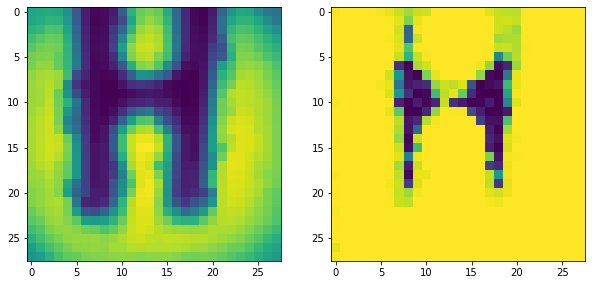

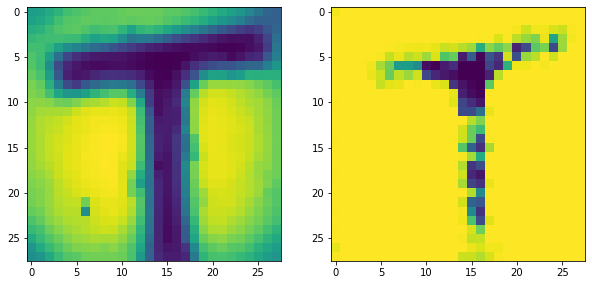

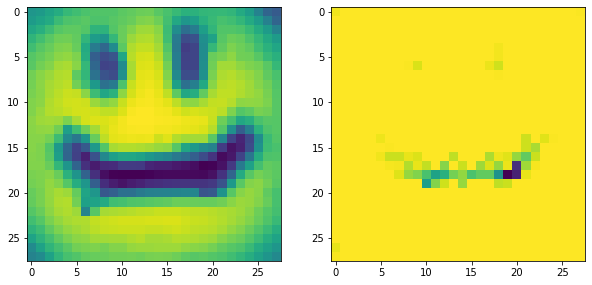

In [91]:
pred = model.model.sample(x[:7].cuda(),7)
pred = torch.clip(pred,0,1)
for N in range(7):
    fig,ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(x[N,0])
    ax[1].imshow(pred[N,0].detach().cpu())

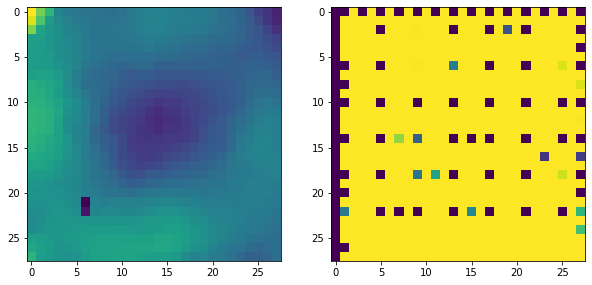

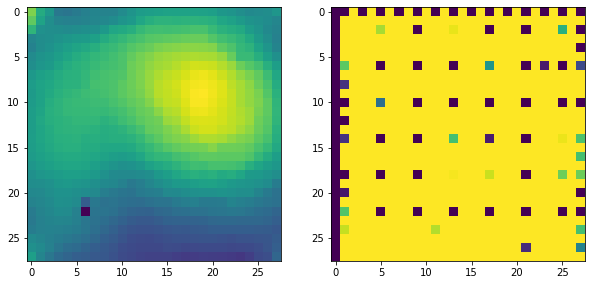

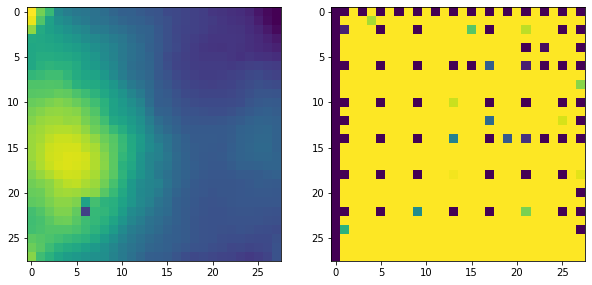

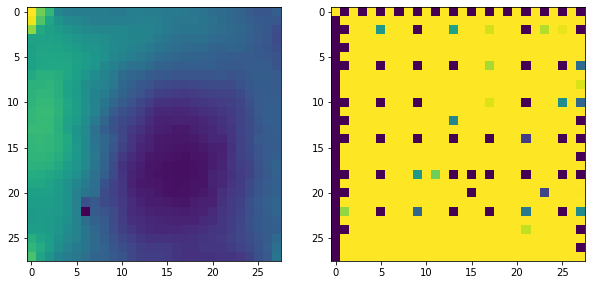

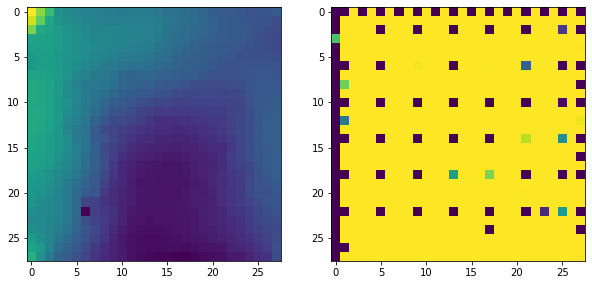

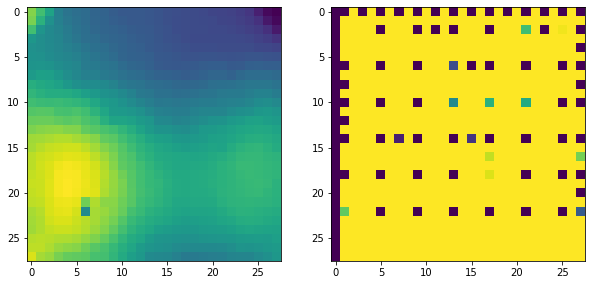

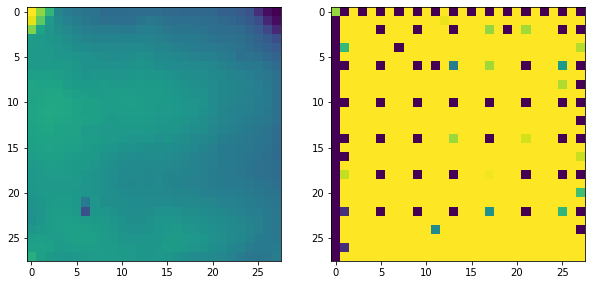

In [92]:
pred = model.model.sample(y[:7].cuda(),7)
pred = torch.clip(pred,0,1)
for N in range(7):
    fig,ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(y[N,0])
    ax[1].imshow(pred[N,0].detach().cpu())